<a href="https://colab.research.google.com/github/VipulGajbhiye/Object-Detection-with-Yolov5/blob/main/Yolo_widgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
#!bash install_colab.sh

--2021-06-26 07:51:02--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979 [text/plain]
Saving to: ‘install_colab.sh’

install_colab.sh    100%[===================>]     979  --.-KB/s    in 0s      

2021-06-26 07:51:02 (60.6 MB/s) - ‘install_colab.sh’ saved [979/979]

Installing icevision + dependencices for CUDA 10
- Installing torch and its dependencies
     |████████████████████████████████| 7.1MB 6.7MB/s 
     |████████████████████████████████| 735.5MB 24kB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.8.0 which is incompatible.
     |████████████████████████████████| 804.1MB 22kB/s 
     |████████████████████████████████| 17.3MB 179k

In [1]:
from icevision.all import *
import ipywidgets as widgets

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"
INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:69
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:16


0B [00:00, ?B/s]

In [2]:
# Download the dataset
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

  0%|          | 0/20380998 [00:00<?, ?B/s]

In [3]:
class_map = ClassMap(["milk_bottle", "carton", "can", "water_bottle"])
parser = parsers.voc(annotations_dir=data_dir / "odFridgeObjects/annotations",
                     images_dir=data_dir / "odFridgeObjects/images",
                     class_map=class_map)
parser.class_map

WARNING  - This function will be deprecated, instantiate the concrete classes instead: `VOCBBoxParser`, `VOCMaskParser` | icevision.parsers.voc_parser:voc:18


<ClassMap: {'background': 0, 'milk_bottle': 1, 'carton': 2, 'can': 3, 'water_bottle': 4}>

In [4]:
train_records, valid_records = parser.parse()

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [6]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [7]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [8]:
extra_args = {}
model_type = models.ultralytics.yolov5
backbone = model_type.backbones.small
# The yolov5 model requires an img_size parameter
extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.ultralytics.yolov5' from '/usr/local/lib/python3.7/dist-packages/icevision/models/ultralytics/yolov5/__init__.py'>,
 {'img_size': 384})

In [9]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

  0%|          | 0.00/14.1M [00:00<?, ?B/s]

In [10]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [12]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=7.585775847473997e-07)

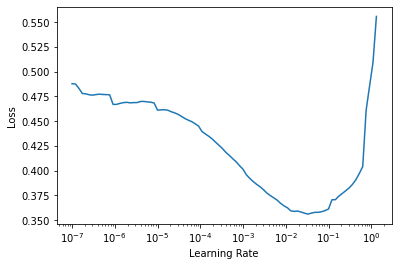

In [13]:
learn.lr_find()

In [14]:
learn.fine_tune(20, 1e-4, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.459609,0.529735,0.000353,00:03


epoch,train_loss,valid_loss,COCOMetric,time
0,0.457316,0.516278,0.000597,00:03
1,0.452423,0.503048,0.001764,00:03
2,0.444364,0.490758,0.003272,00:03
3,0.437342,0.476291,0.004699,00:03
4,0.427163,0.461169,0.010478,00:03
5,0.415284,0.445965,0.020504,00:03
6,0.404597,0.432325,0.039819,00:04
7,0.392850,0.417872,0.059616,00:03
8,0.382657,0.406045,0.076725,00:03
9,0.371080,0.393551,0.095866,00:03


In [15]:
learn.fine_tune(100, 3e-3, freeze_epochs=1)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.290581,0.313046,0.297623,00:03


epoch,train_loss,valid_loss,COCOMetric,time
0,0.248478,0.296749,0.385281,00:03
1,0.234044,0.277331,0.437370,00:04
2,0.219866,0.263100,0.385884,00:03
3,0.207440,0.251960,0.406599,00:03
4,0.197119,0.252200,0.417156,00:03
5,0.186988,0.229309,0.522710,00:03
6,0.180049,0.218116,0.656290,00:03
7,0.171408,0.211411,0.669524,00:03
8,0.163294,0.195862,0.683746,00:03
9,0.155638,0.189259,0.680238,00:03


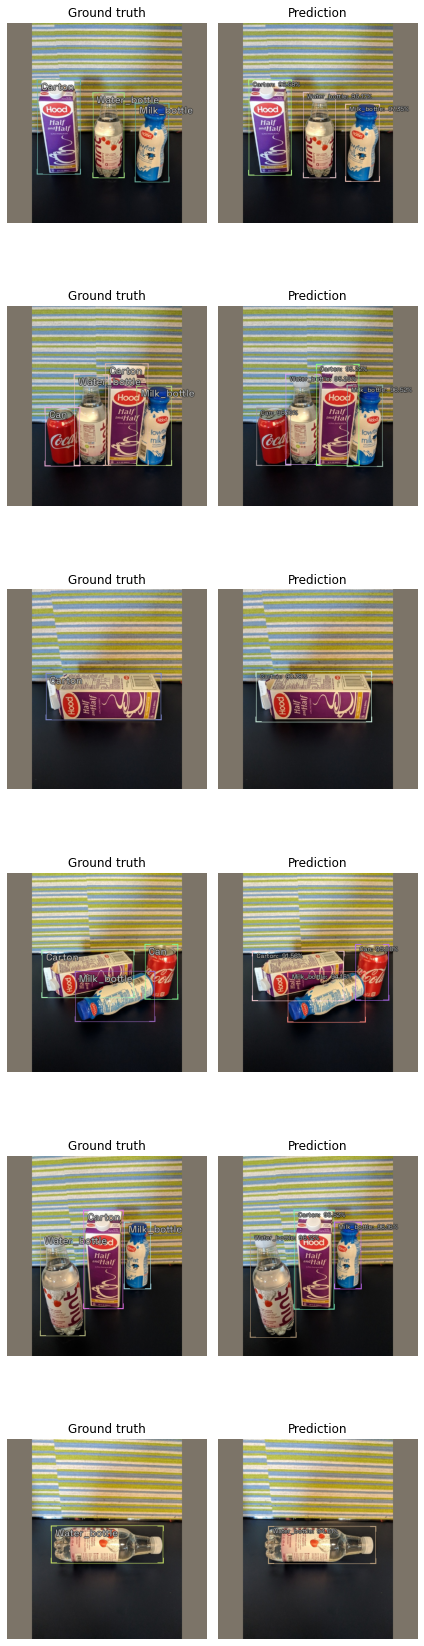

In [16]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [29]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/7 [00:00<?, ?it/s]

In [140]:
iou_thres = widgets.IntSlider(value=1, min=1, max=40, step=1, description="Number")

In [141]:
btn_run = widgets.Button(description="Detect")

In [142]:
labl_pred = widgets.HTML()#widgets.Label()

In [143]:
out_img = widgets.Output()
out_img.clear_output()

In [150]:
def on_click_classify(change):
    out_img.clear_output()
    with out_img:
        display(show_preds(preds=preds[:iou_thres.value]))


In [145]:
btn_run.on_click(on_click_classify)


In [146]:
instruction_labl = widgets.Label("Number of Images For Prediction")

In [151]:
input_widgets = widgets.VBox([instruction_labl,iou_thres,widgets.HBox([btn_run])])

In [152]:
output_widgets = widgets.HBox([out_img])

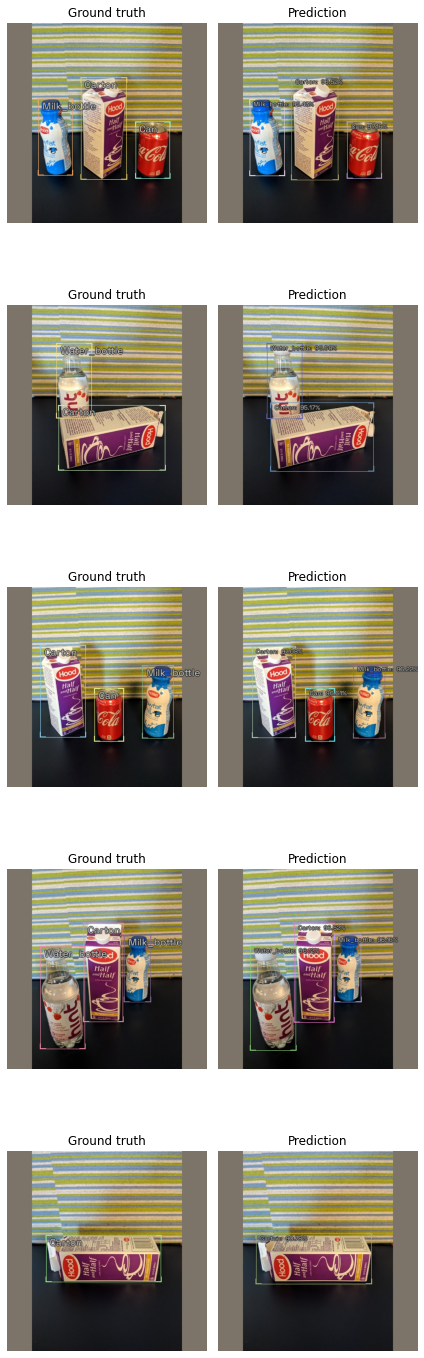

In [153]:
widgets.VBox([input_widgets, output_widgets])